<a href="https://colab.research.google.com/github/amrit-thapa-2044/ICIMOD_permafrost_training_2022/blob/main/extract_MODIS_LST_4m_GEE_my_lon_lat_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

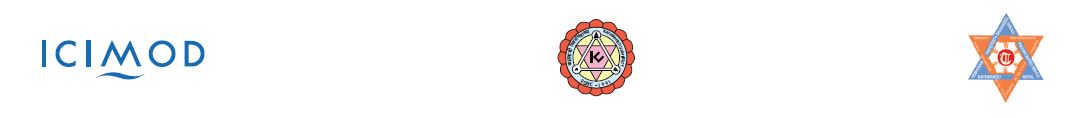

**<div align="center"><font size="4">REGIONAL TRAINING</font>**
<div align="center"><font size="4">Analysing permafrost in the Hindu Kush Himalaya using open access tools</font>

**<h2 align='center'>Extracting MODIS Land Surface Temperature from Google Earth Engine (GEE) to point location**

*This notebook is prepared for the participants of the regional training on [Analysing permafrost in the Hindu Kush Himalaya using open access tools](https://www.icimod.org/event/analysing-permafrost-in-the-hindu-kush-himalaya-using-open-access-tools/) by [ICIMOD](https://www.icimod.org/) through its [Cryosphere Initiative](https://www.icimod.org/initiative/cryosphere/) under the Regional Programme on [River Basins and Cryosphere](https://www.icimod.org/regional-programme/river-basins-and-cryosphere/) in collaboration with [Kathmandu University]() and [Tribhuvan University](http://www.tribhuvan-university.edu.np/).*

*The Cryosphere Initiative is supported by the Government of Norway and Swiss Agency for Development and Cooperation.*


Coded by: \
Amrit Thapa \
Email: amrit.thapa@icimod.org \
GitHub: https://github.com/amrit-thapa-2044

---



***This exercise is conducted using the [python](https://www.python.org/) coding language.*** A [GEE](https://earthengine.google.com/) account has to be opened before executing this exercise. You can signup for GEE following this [link](https://training.eumetsat.int/mod/page/view.php?id=13074). A [Gmail](https://accounts.google.com/signup) account is required to register to GEE.

# Why to analyze Land Surface Temperature (LST) ?


- LST is an important parameter for the energy budget of permafrost environments.
- LST values can help distinguish between frozen and unfrozen ground.

# Authenticate GEE and initiate library
Earth Engine Python API is installed by default in Google Colaboratory, so all that needs to be done is import it and authenticate it. 

In [ ]:
#load/import library
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Each time that you start Colab, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity, it must be done.

Above step allows us to communicate with GEE. Now, we are set to pull data from Earth Engine's public data archive. You can explore dataset available in [Earth Engine's public data archive](https://developers.google.com/earth-engine/datasets).

# Define user variables
Let's define some variables to extract MODIS LST. The mandatory variables to be defined are: 
- the [sensor/satellite](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MYD11A1#description) to be used
- the time period to cover
- [band/variable](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MYD11A1) name as sensors can have more than one variable
- latitude and longitude to use for the data extraction
- the spatial resolution of the data (scale)

In [ ]:
# the name of the sensor/satellite to download data
sensor='MYD11A1' # MOD11A1 or MYD11A1

# initial date of interest (inclusive).
i_date = '2003-01-01'

# Final date of interest (exclusive).
f_date = '2020-12-31'

# define variable of interest
my_variable='LST_Night_1km' # 'LST_Day_1km' or 'LST_Night_1km'

# Define the location of your interest as point geometry
my_lon = 86
my_lat = 28.5

# spatial resolution of the product
scale = 1000

# Convert longitude and latitude to geometry
In GEE the feature class (point, line and polygon ) has to be imported as a geometry object. For this exercise, we are interested in extracting data at a point location. So, let's convert longitude and latitude to a point geometry.

This can be done by using ***ee.Geometry.Point*** function. It takes two arguments (*coords, proj* (optional)).
- *coords*:	a list of two [x,y] coordinates in the given projection.
- *proj*:	the projection of this geometry, or EPSG:4326 if unspecified.

In [ ]:
my_point = ee.Geometry.Point(my_lon, my_lat)

# Load image collection
Our next step is to load the image collection (stack of images) that we want to download. This can be done by calling the ***ee.ImageCollection*** function. By pasting an asset ID into the ImageCollection constructor, an ImageCollection can be loaded from Earth Engine. The ID of the ImageCollection can be found in the [data catalog](https://developers.google.com/earth-engine/datasets/catalog). The code below loads the MODIS Aqua LST image collection.

In [ ]:
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/'+sensor)

# Filter image collection
We would now like to select specific bands in the image collection using the ***select*** function. For the purpose of this example, we want MODIS LST data. This product has different [bands](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MYD11A1). Now let's download LST_Night_1km band. Furthermore, we can use the ***filterDate*** function to filter dates at the same time. Each filter is connected to another using the dot (***.***) operator.

In [ ]:
# Selection of appropriate bands and dates for LST.
lst = lst.select(my_variable).filterDate(i_date, f_date)

# Extract value from image collection
In above steps, we loaded the image collection and filtered the image collection to select specific band and time slot. Now we are ready to extract the data at point location. This can be done by applying **getRegion** function.

The expression for this function is 

*ImageCollection*.**getRegion**(*geometry, scale, crs*)

- *ImageCollection*: image collection to extract data from.
- *geometry*: region over which to extract data.
- *scale*: nominal scale in meters of the projection to work in.
- *crs*: projection to work in.


In [ ]:
# Get the data for the pixel intersecting our point.
lst_my_point = lst.getRegion(my_point, scale).getInfo()

In [ ]:
# Preview first 6 rows of the result.
lst_my_point[:6]

# Convert result to dataframe
The output is an array. We would like to plot the data using ggplot and export the output as a CSV. To do this, we need data in dataframe format. Now, let's create a function to convert the array to a dataframe. We have already discussed how to define a function in Python. 

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
# apply function to convert array to dataframe
lst_df_my_point = ee_array_to_df(lst_my_point,[my_variable])

# Convert LST from Kelvin to Degree Celsius
MODIS LST data are available in Kelvin with a scale factor of 0.02. But it can be easily converted to an absolute value (degrees Celsius) by using the following conversion:

$LST (Degree C)= 0.02 * LST(Kelvin) - 273.15$.
 
 Let's do this.We will define a function and apply it over entire dataframe to convert Kelvin to degree Celsius.

In python, we use **def** for defining a function. It uses the following components.

- keyword **def** that marks the start of the function header.
- a function name to uniquely identify the function. 
- a colon (:) to mark the end of the function header.
- optional documentation string (docstring) to describe what the function does.
- one or more valid python statements that make up the function body.
- statements must have the same indentation level (usually 4 spaces).
- optional return statement to return a value from the function.


In [ ]:
def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_my_point[my_variable] = lst_df_my_point[my_variable].apply(t_modis_to_celsius)

In [ ]:
# visualize head of the output
lst_df_my_point.head()

In [ ]:
# delete first column as we have already converted time to date 
del lst_df_my_point["time"]
lst_df_my_point.head()

We have already converted time to date, so we can delete the first column.

# Visualize downloaded visualization
For this notebook, we will use the python package [plotnine](https://plotnine.readthedocs.io/). Plotnine is an implementation of a grammar of graphics in Python. This package is based on [ggplot2](https://ggplot2.tidyverse.org/) from the [R](https://cran.r-project.org/) programming language. Additionally, we use [mizani](https://mizani.readthedocs.io/), a python library that provides the function necessary to create scales for a graphics system. It is based on the R [scales](https://scales.r-lib.org/) package. The colab notebook already contains both of these packages. They just need to be loaded.

In [ ]:
# load required packages
from plotnine import* # asterisk (*) means load all functions from plotnine
from mizani.breaks import date_breaks
from mizani.formatters import date_format

Let's make a plot. The ggplot funcion uses basic building blocks according to the grammar of graphics as follows

- data: data + a set of aesthetic mappings that describe variables mapping
- geom: geometric objects represent what you actually see on the plot: points, lines, polygons, etc.
 More detail about ggplot in python is [here](https://monashdatafluency.github.io/python-workshop-base/modules/plotting_with_ggpl).



In [ ]:
plot_daily_LST=(
    ggplot(lst_df_my_point)  # What data to use
    + geom_line(aes(x="datetime", y="LST_Night_1km"),colour='red')
    +ylab('LST (degree C)')+xlab('Year')
    + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y-%m'))
    +ggtitle(sensor+' '+my_variable+' at lon= '+str(my_lon)+' lat ='+str(my_lat))
    +theme(figure_size=(10, 5)) #x,y)
)

print(plot_daily_LST)

# Convert daily LST to annual values (MAST)

MAST (mean annual surface temperatures) is an important permafrost index, used to detect the presence of permafrost. MAST is derived by aggregating daily LST at an annual scale. 

Let's take a look at the daily LST conversion. This is done using the resample function. Details about the use of this function is available [here](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/resample-time-series-data-pandas-python/).

It is necessary to convert the date to an index before using the resample function.


In [ ]:
# convert date colum to index
df_lst_my_point = lst_df_my_point.set_index('datetime') 

# aggregate daily to annual mean values
df_annual_LST=df_lst_my_point.resample('Y').mean()

# visualize first five rows to check output dataframe
df_annual_LST.head()

From the above dataframe, we notice that the datetime column is no more a column but they are now row names. So, let's restructure rows name as a column and produce a plot.

In [ ]:
# define a column name for row  <if you rerun this line you may get error, in that case run from immediate step>
df_annual_LST.index.name = 'Year'

# reset index as a column
df_annual_LST.reset_index(inplace=True)

# visualize  first five rows
df_annual_LST.head()

Let's visualize the MAST using ggplot.

In [ ]:
plot_MAAT=(
    ggplot(df_annual_LST)  # What data to use
    + geom_line(aes(x="Year", y="LST_Night_1km"),colour='red')
    + geom_point(aes(x="Year", y="LST_Night_1km"),colour='blue')
    +ylab('MAST (degree C)')+xlab('Year')
    + scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    +ggtitle('MAST from '+sensor+' '+my_variable+' at lon= '+str(my_lon)+' lat ='+str(my_lat))
    +theme(figure_size=(10, 5)) #x,y)
)

print(plot_MAAT)

Question: Assess the magnitude and pattern of mean annual land surface temperature (MAST) and discuss how it relates with the permafrost process in a group of 3-4 participants.

# Export/download data to local machine
Colab also provides a function to download data directly to the local machine. From the **google.colab** package, we can use the **files.download** function to download output.


In [ ]:
# load necessary files
from google.colab import files

# define output filename
my_filename=sensor+'_'+my_variable+'_lon_'+str(my_lon)+'_lat_'+str(my_lat)+'_'+i_date+'_'+f_date+'.csv'
print('my file name is: ',my_filename)

# Convert dataframe to csv
lst_df_my_point.to_csv(my_filename, encoding = 'utf-8-sig') 

# download csv
files.download(my_filename)

It is important to evaluate the accuracy and precision of the LST products before we use them. Remote sensing and reanalysis datasets are available along with metadata. Read the metadata carefully before using the data.

Assignment:
- download MODIS LST data to your own point location over permafrost research site and convert to annual mean series (MAST).
- make time series plot of MAST and discuss the nature of the magnitude of data in a group of 3-4 participants.
- make a seasonal plot to understand monthly variability of daily LST data and discuss the pattern.

: <h1 align='center'>**THANK YOU**</h1>